In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

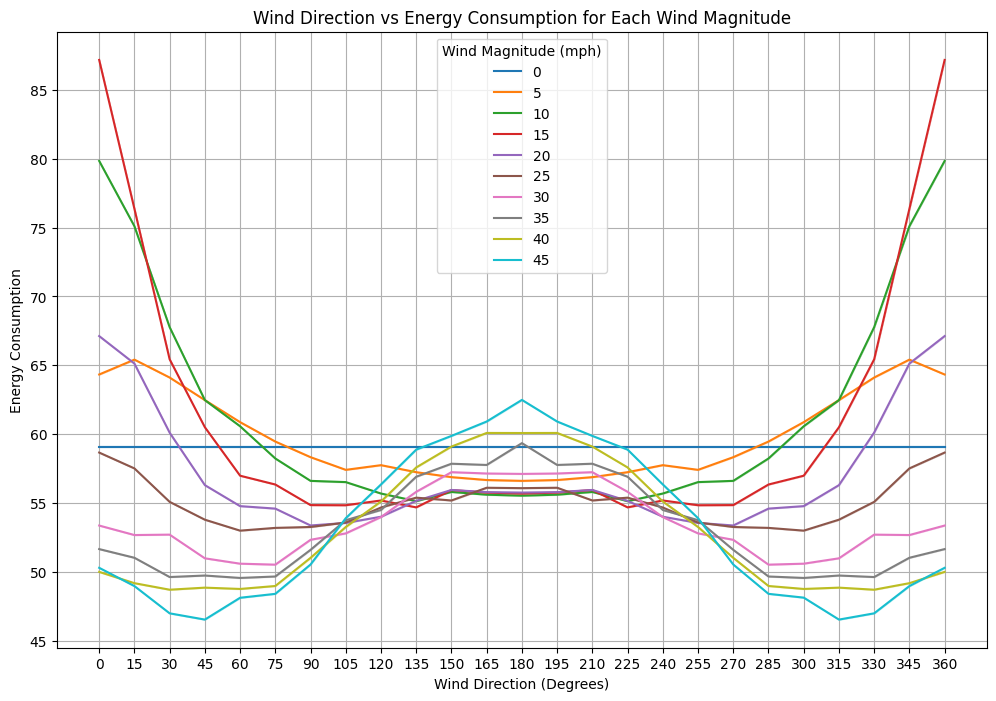

In [2]:
# Reconnect to the SQLite database
conn = sqlite3.connect('energy_and_flight_time.sqlite')

# Query to select the relevant columns
query = """
SELECT energy_consumption, wind_direction_degrees, wind_magnitude_mph
FROM flight_metrics
"""

# Loading the data into a pandas DataFrame
df = pd.read_sql_query(query, conn)

# Close the database connection
conn.close()

# Plotting for WARNER_HHR
plt.figure(figsize=(12, 8))
sns.lineplot(data=df, x='wind_direction_degrees', y='energy_consumption', hue='wind_magnitude_mph', palette='tab10')
plt.title('Wind Direction vs Energy Consumption for Each Wind Magnitude')
plt.xlabel('Wind Direction (Degrees)')
plt.ylabel('Energy Consumption')
plt.xticks(list(range(0, 365, 15)))
plt.legend(title='Wind Magnitude (mph)')
plt.grid(True)
plt.show()


In [10]:
file_path = 'updated_sfo_sjc_route_60_miles.csv'
data = pd.read_csv(file_path)

# Remove rows with NaN values
data_cleaned = data.dropna()

# Summing energy consumption values for each flight phase for each flight direction
grouped_data = data_cleaned.groupby(['flight_direction', 'phase'])['energy_consumption'].sum().reset_index()

# Display the grouped data to verify before plotting
grouped_data.head()

,flight_direction,phase,energy_consumption
0,SFO_SJC,CLIMB,4.56
1,SFO_SJC,CLIMB TRANSITION,3.89
2,SFO_SJC,CRUISE,20.40
3,SFO_SJC,DESCENT,2.37
4,SFO_SJC,DESCENT TRANSITION,3.13


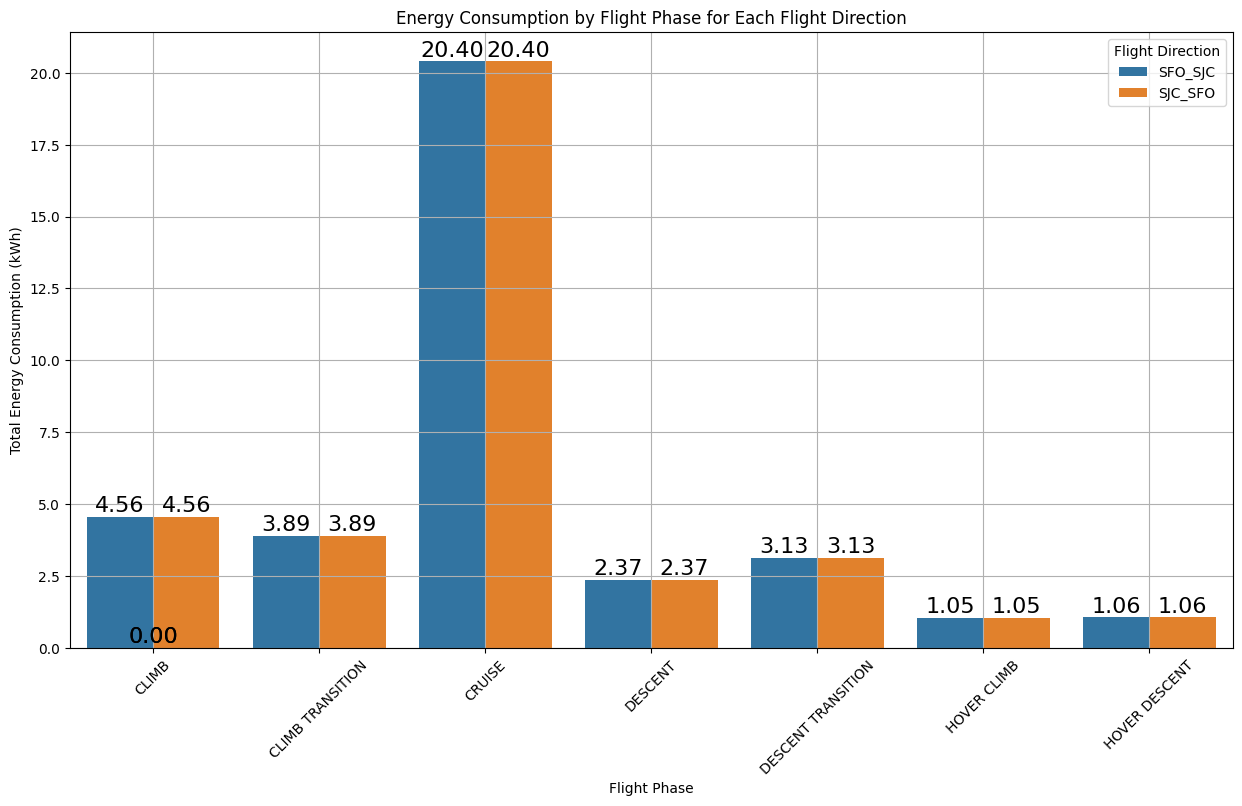

In [11]:
# Plotting all flight directions in the same bar plot with a legend to identify them
plt.figure(figsize=(15, 8))
sns.barplot(x='phase', y='energy_consumption', hue='flight_direction', data=grouped_data, palette='tab10')

# Adding values on top of the bars
for bar in plt.gca().patches:
    plt.gca().annotate(format(bar.get_height(), '.2f'), 
                       (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                       ha='center', va='center', 
                       size=16, xytext=(0, 8), 
                       textcoords='offset points')

plt.title('Energy Consumption by Flight Phase for Each Flight Direction')
plt.xlabel('Flight Phase')
plt.ylabel('Total Energy Consumption (kWh)')
plt.legend(title='Flight Direction')
plt.xticks(rotation=45)
plt.grid()
plt.show()
